# Time Series Analysis
# Exercise 1

In [1]:

# ------------------------- #
# By Srijan Bhushan         #
# Roll No: MDS202039        #
# email: srijanb@cmi.ac.in  #
# Time Series Analysis      #
# Exercise/ Assignment 1    #
# ------------------------- #

# All python code will be in boxes like these
# and the relevant output below
print("This is python code output.")


This is python code output.


# Data Preparation
## Importing the data

before we begin anything, we first import various required python libraries  
and import the HDFC stock data as well

Our stock data source is from:  
https://finance.yahoo.com/quote/HDFCBANK.NS/history?period1=1476662400&period2=1634428800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true  
We further filtered data of the stock from date 17 Oct 2016 to 17 Oct 2021
and try to forecast on the ```Adj Close``` price of the stock

In [2]:
# importing python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arch.unitroot as stat_tests
import datetime
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [3]:
# loading our data into the python variable 'data'
# data is from: https://finance.yahoo.com/quote/HDFCBANK.NS
data = pd.read_csv('HDFCBANK.NS.csv')[['Date', 'Adj Close']]
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data = data.set_index('Date');


## Some basic visualisations / exploratory visualisations

In [4]:
# let us have a look at our data
data.head(10)


,Adj Close
Date,
2016-10-17,603.131592
2016-10-18,612.950745
2016-10-19,613.194397
2016-10-20,611.805603
2016-10-21,619.212585
2016-10-24,615.728394
2016-10-25,609.271606
2016-10-26,603.911377
2016-10-27,610.148743


<AxesSubplot:title={'center':'Plot of HDFC Adj Close data from 2017 to 2021'}, xlabel='Date'>

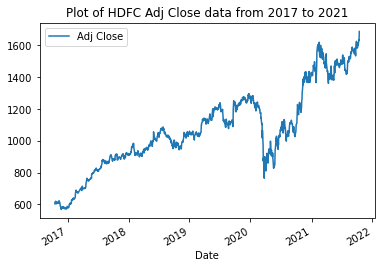

In [5]:
# let us plot our data
data.plot(title='Plot of HDFC Adj Close data from 2017 to 2021')


## Deciding how much data is relevant

One can observe that there is a sharp fall during the year 2020, we hypothesize that this might be
due to the coronavirus pandemic that had just started during that time.
Thus, all data prior to 2020 is not of relevance, since the conditions (i.e. existence of covid) was not the same during that time.
The article: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7530459/ mentions that the first covid case in
India was on 27th Jan 2020, hence for the purpose of our forecase, all data before that date is considered
irrelevant.

We thus, set a variable ```relevant_data``` which contains stock data only after the covid impact in India.
In fact, to be safe we take the data from when the "covid curve" in India had started flattening.
To find this data, we had looked across the internet and rather than finding the kurtosis for finding the peak,
we decided, in order to save time, that a rough estimate would work just as fine.
As such, we found this graph: https://www.arcgis.com/apps/dashboards/bda7594740fd40299423467b48e9ecf6 (*)
which plots india's second wave curve which starts falling around May 2021.

Hence, our data before May 2021 will be considered as irrelevant.

---
(*) Note: In the website one has to select India on the left and view the red graph on the right

In [6]:
# so we now have our relevant data
relevant_data = data[data.index >= '2021-05-01']


## Preparing our relevant data
Let us look at a few rows of our data

In [7]:
relevant_data.head(10)


,Adj Close
Date,
2021-05-03,1408.354614
2021-05-04,1382.367065
2021-05-05,1396.555664
2021-05-06,1394.863037
2021-05-07,1408.653320
2021-05-10,1413.731323
2021-05-11,1397.501709
2021-05-12,1393.469116
2021-05-14,1380.873535


In [8]:
print(f"Our data contains {relevant_data.shape[0]} rows")


Our data contains 115 rows


### Check for missing values

In [9]:
print(f"Our data contains {relevant_data.isna().sum()[-1]} missing values")


Our data contains 0 missing values


so we don't have any missing values.  

### Outlier Capping 
We first print the range of 3 standard deviation

In [10]:
print(f"Range is:({relevant_data.mean()[-1] - 3*relevant_data.std()[-1]}, {relevant_data.mean()[-1] + 3*relevant_data.std()[-1]})")


Range is:(1318.0863469716214, 1700.7803267327263)


We now cap our data (regardless of if there are outliers or not)

In [11]:
lim_sup = relevant_data.mean()[-1] + 3*relevant_data.std()[-1]
lim_inf = relevant_data.mean()[-1] - 3*relevant_data.std()[-1]

# capping on lim_sup
temp_copy = relevant_data["Adj Close"].copy()
relevant_data["Adj Close"] = np.where(temp_copy > lim_sup, lim_sup, temp_copy)

# capping on lim_inf
temp_copy = relevant_data["Adj Close"].copy()
relevant_data["Adj Close"] = np.where(temp_copy < lim_inf, lim_inf, temp_copy)


## Descriptive statistics of data

Note:
- std = standard deviation
- x% = value of x-th percentile

In [12]:
relevant_data.describe()


,Adj Close
count,115.000000
mean,1509.433337
std,63.782330
min,1380.873535
25%,1473.248779
50%,1501.849976
75%,1558.125000
max,1687.400024


In [13]:
# We find the IQR range here

# iqr upper bound
iqr_sup = relevant_data.mean()[-1] + (1.5)*relevant_data.std()[-1]

# iqr lower bound
iqr_inf = relevant_data.mean()[-1] - (1.5)*relevant_data.std()[-1]

# no. of values in irq range
count = relevant_data['Adj Close'].between(iqr_inf, iqr_sup).sum()

print(f"There is approx {round(count/relevant_data.shape[0]*100,2)}% of data in IQR range")


There is approx 85.22% of data in IQR range


In [14]:
# we look at a description of the data
# we have 115 rows, so that's enough for training and forecasting
relevant_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 115 entries, 2021-05-03 to 2021-10-14
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  115 non-null    float64
dtypes: float64(1)
memory usage: 1.8 KB


## Plot of our data

<AxesSubplot:title={'center':'Plot of HDFC Adj Close prices from May 2021 to October 2021'}, xlabel='Date'>

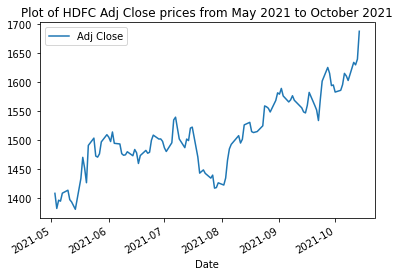

In [15]:
# let us plot our relevant data
relevant_data.plot(title='Plot of HDFC Adj Close prices from May 2021 to October 2021')


## Split data for Model and Forecast / testing
We now perform exclude a few end dates from our data to test how good our forecast models are

In [16]:
# This data will be used for testing our forecasting
test_data = relevant_data[-5:]

# This data will be used for building our ARIMA model
model_data = relevant_data[:-5]


### Let us view few first 5 columns of each of our data

In [17]:
print("Some of the data that will be used for training")
model_data.head(5)


Some of the data that will be used for training


,Adj Close
Date,
2021-05-03,1408.354614
2021-05-04,1382.367065
2021-05-05,1396.555664
2021-05-06,1394.863037
2021-05-07,1408.653320


In [18]:
print("Final few rows of data that will be used for training")
model_data.tail(5)


Final few rows of data that will be used for training


,Adj Close
Date,
2021-10-01,1582.699951
2021-10-04,1585.750000
2021-10-05,1595.449951
2021-10-06,1614.900024
2021-10-07,1610.500000


In [19]:
print("Data we will be forecasting")
test_data.head(5)


Data we will be forecasting


,Adj Close
Date,
2021-10-08,1602.650024
2021-10-11,1633.800049
2021-10-12,1629.599976
2021-10-13,1639.400024
2021-10-14,1687.400024


**Note: We will forecast from 8th October, so our training data ends on 7th October and our
test data begins on 8th October**

(Furthermore: 9th and 10th October of year 2021 were weekends and as such, the market remains closed: so there
is no data for those days)

In [20]:
print(f"""We have:
- {model_data.shape[0]} rows for model building
- {test_data.shape[0]} rows for testing our forecast""")


We have:
- 110 rows for model building
- 5 rows for testing our forecast


So we will now perform our forecasting on the data in ```model_data``` and observe our results on ```test_data```

# Check for stationarity
We employ the follwing tests:
- Phillip Perron Test (pp)
- Augmented Dickey Fuller Test (adf)
- Kwiatkowski Phillips Schmidt Shin Test (kpss)

The hypotheses for the tests are as follows:
- For pp and adf
    - Null: There is a unit root (implying time series is not stationary)
    - Alter: The time series is stationary

- For kpss
    - Null: The time series is stationary
    - Alter: The time series is not stationary

Thus, for check stationarity of our data we need pp and adf tests to reject null hypothesis
but kpss should not be able to reject null hypothesis.

As such, for the function ```station_check()```, we print ```True``` for pp and adf in case they
reject null in favor of considering the time series as stationary.

Whereas for kpss we print ```True``` in the case it can't reject null and hence, cannot reject the possibility
of the time series being stationary.

In [21]:
def station_check(entries, pvalue=0.05):
    pp = stat_tests.PhillipsPerron(entries)
    adf = stat_tests.ADF(entries)
    kpss = stat_tests.KPSS(entries)
    # (calculated_pvalue < provided_pvalue) --> reject null
    pp_res, adf_res, kpss_res = pp.pvalue < pvalue, adf.pvalue < pvalue, kpss.pvalue < pvalue
    print(f"""Stationary Checks:
(True = Test suggests data is stationary. False = Test suggests data is *not* stationary)
    - pp   verdict: {pp_res == True}
    - adf  verdict: {adf_res == True}
    - kpss verdict: {kpss_res == False} 
    """)
# kpss has a different null that's why '== False' for kpss


In [22]:
station_check(model_data['Adj Close'])


Stationary Checks:
(True = Test suggests data is stationary. False = Test suggests data is *not* stationary)
    - pp   verdict: False
    - adf  verdict: False
    - kpss verdict: False 
    


All 3 Tests show False, so the data is not stationary.  
We shall now transform our data in hopes to make it stationary

In [23]:
def transformer1(data):
    # taking first difference values
    return data.diff()[1:]

def transformer2(data):
    # transforming values into log
    return np.log(data)

def transformer3(data):
    # transforming values and then taking first difference
    return np.log(data).diff()[1:]


In [24]:
transform1 = transformer1(model_data['Adj Close'])
transform2 = transformer2(model_data['Adj Close'])
transform3 = transformer3(model_data['Adj Close'])


In [25]:
print("-- No Transform --")
station_check(model_data['Adj Close'])

print("\n-- Transform 1: First difference --")
station_check(transform1)

print("\n-- Transform 2: Taking log of the values --")
station_check(transform2)

print("\n-- Transform 3: Taking log of the values and then taking first difference --")
station_check(transform3)


-- No Transform --
Stationary Checks:
(True = Test suggests data is stationary. False = Test suggests data is *not* stationary)
    - pp   verdict: False
    - adf  verdict: False
    - kpss verdict: False 
    

-- Transform 1: First difference --
Stationary Checks:
(True = Test suggests data is stationary. False = Test suggests data is *not* stationary)
    - pp   verdict: True
    - adf  verdict: True
    - kpss verdict: True 
    

-- Transform 2: Taking log of the values --
Stationary Checks:
(True = Test suggests data is stationary. False = Test suggests data is *not* stationary)
    - pp   verdict: False
    - adf  verdict: False
    - kpss verdict: False 
    

-- Transform 3: Taking log of the values and then taking first difference --
Stationary Checks:
(True = Test suggests data is stationary. False = Test suggests data is *not* stationary)
    - pp   verdict: True
    - adf  verdict: True
    - kpss verdict: True 
    


From the above we can see that ```transform1``` i.e. taking first difference, is a simple way of making 
our times series data stationary

In [26]:
data_diff1 = transformer1(model_data['Adj Close'])


Let us now plot this data

<AxesSubplot:title={'center':'Plot of first difference of adj. close price of HDFC stock'}, xlabel='Date'>

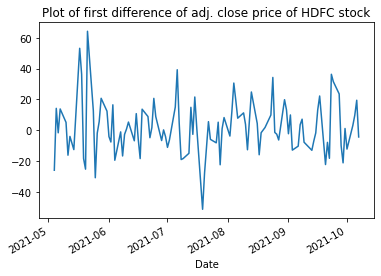

In [27]:
data_diff1.plot(title='Plot of first difference of adj. close price of HDFC stock')


# Estimating p,q in ARMA(p,q)

In [28]:
p_lim = 15
q_lim = 15
p_range = [i for i in range(p_lim+1)]
q_range = [i for i in range(q_lim+1)]
aic_matrix = [[None for _ in range(p_lim+1)] for __ in range(q_lim+1)]
bic_matrix = [[None for _ in range(p_lim+1)] for __ in range(q_lim+1)]


In [29]:
for p in p_range:
    for q in q_range:
        if p == 0 and q == 0:
            # arma(0,0) set to a high number (basically no prediction)
            aic_matrix[q][p] = 9999
            bic_matrix[q][p] = 9999
        else:
            # initializing arma(p,q) model
            model = ARIMA(data_diff1, order=(p,0,q))
            
            # fitting model to data
            results = model.fit()
            
            # recording the calculated aic and bic scores
            aic_matrix[q][p] = round(results.aic,3) # Imp: we set it as (q,p) not the usual (p,q)
            bic_matrix[q][p] = round(results.bic,3) # Imp: we set it as (q,p) not the usual (p,q)
print("Scores Calculation Done")  


Scores Calculation Done


In [30]:
# converting to numpy array for better computations
aic_matrix = np.array(aic_matrix)
bic_matrix = np.array(bic_matrix)


In [31]:
print(f"Best index as per aic:{np.argwhere(aic_matrix == np.min(aic_matrix))}, score: {np.min(aic_matrix)}")
print(f"Best index as per bic:{np.argwhere(bic_matrix == np.min(bic_matrix))}, score: {np.min(bic_matrix)}")


Best index as per aic:[[10  0]], score: 917.693
Best index as per bic:[[0 2]], score: 936.753


For fitting ARMA(p,q) model:
- aic recommends (q,p) = (10,0)
- bic recommends (q,p) = (0,2)


We will use bic's recommendation
because bic is emperically better as per this:
https://stats.stackexchange.com/questions/577/is-there-any-reason-to-prefer-the-aic-or-bic-over-the-other

## Building our ARMA(p,q) model

In [32]:
final_model = ARIMA(data_diff1, order=(2,0,0))
results = final_model.fit()


In [33]:
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                  109
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -458.994
Date:                Wed, 03 Nov 2021   AIC                            925.988
Time:                        23:26:34   BIC                            936.753
Sample:                             0   HQIC                           930.354
                                - 109                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8269      1.446      1.264      0.206      -1.007       4.660
ar.L1          0.1819      0.096      1.897      0.058      -0.006       0.370
ar.L2         -0.3417      0.103     -3.323      0.001      -0.543      -0.140
sigma2       265.5471     31.396      8.458      0.000     204.012     327.083
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                19.61
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             0.64
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Forecasting

We try to forecast the next 5 values (i.e. values in the ```test_data``` as seen before

In [34]:
# Value of $Y_T$ i.e. last recorded value
model_data.iloc[109]


Adj Close    1610.5
Name: 2021-10-07 00:00:00, dtype: float64

We use the inbuilt functions to find the forecasts for the next 5 values

In [35]:
# finding the forecasts of first difference time series
forecasts = results.predict(start=109, end=113)


In [36]:
# let us look at the forecasts
forecasts


109   -5.327282
110    2.653411
111    4.421674
112    2.016345
113    0.974696
Name: predicted_mean, dtype: float64

In [37]:
# predicting the value for date '2021-10-08' i.e. 8th october 2021
# we need to add since we had trained on first difference
forecasts.iloc[0] += 1610.5


In [38]:
forecasts

109    1605.172718
110       2.653411
111       4.421674
112       2.016345
113       0.974696
Name: predicted_mean, dtype: float64

In [39]:
# cumsum() just outputs the cumulative sum:
# which is basically some sort of an inverse transformation
# of the first difference
predicted_values = forecasts.cumsum()


In [40]:
# here are our final predicted values
predicted_values


109    1605.172718
110    1607.826129
111    1612.247803
112    1614.264148
113    1615.238844
Name: predicted_mean, dtype: float64

In [41]:
# what were the true values:
test_data


,Adj Close
Date,
2021-10-08,1602.650024
2021-10-11,1633.800049
2021-10-12,1629.599976
2021-10-13,1639.400024
2021-10-14,1687.400024


In [42]:
# we now plot our data
x = [str(y) for y in test_data.index]


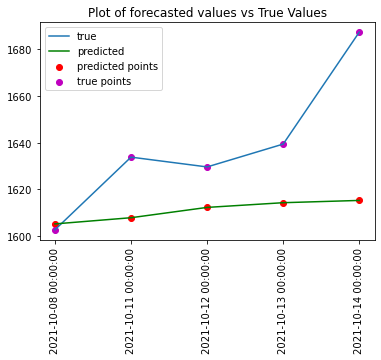

In [43]:
# plotting code
plt.scatter(x, predicted_values, label='predicted points', color='r')
plt.plot(x, test_data['Adj Close'], label='true')
plt.plot(x, predicted_values, label='predicted', color='g')
plt.scatter(x, test_data['Adj Close'], label='true points', color='m')
plt.legend()
plt.xticks(rotation=90)
plt.title("Plot of forecasted values vs True Values")
plt.show()


In [44]:
# calculation of error scores code
predicted_values.index = [1,2,3,4,5]
test_data.index = [1,2,3,4,5]
mse = np.mean( (predicted_values - test_data['Adj Close'])**2 )
print(f"MSE of forecasts: {mse}")
print(f"RMSE of forecasts: {np.sqrt(mse)}")
print("------")
print(f"Squared error of first forecast: {predicted_values.iloc[0] - test_data['Adj Close'].iloc[0]}")

MSE of forecasts: 1364.2309221650949
RMSE of forecasts: 36.93549677701783
------
Squared error of first forecast: 2.5226944353059935


# Findings

We see that our ARMA model has a decent first step forecast prediction after which
it quickly becomes worse.

We do not find that very surprising due to 2 major factors:  
   - Covid is still going: and hence, any forecast during these uncertain times are bound to fail quickly  
   - Stocks are hard to predict: if all it took to predict adjusted close of a stock was an ARIMA model then
   there would be no need to study further. In general, we have failed to consider a lot of factors: Trends,
   impact of our predictions on models, decisions of other traders based on our actions, etc